In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(["."]+chars)}
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [5]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   # training
Xdev, Ydev = build_dataset(words[n1:n2]) # dev
Xte,  Yte  = build_dataset(words[n2:])   # test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [75]:
# mlp
n_embed = 10 # dimensionality of the character embedding
n_hidden = 200 # n neurons in hidden layer of MLP

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embed), generator=g)          # vocabulary lookup into embedding
# the "kaiming-init"
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) *(5/3)/(n_embed*block_size)**.5 # * 0.2 # embedding into latent space
b1 = torch.randn(n_hidden, generator=g) * 0.1                      # latent space bias
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1   # embedding into vocabulary one-hot
b2 = torch.randn(vocab_size, generator=g) * 0                 # vocabulary bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
# why can't you set W2 to zero to get that expected value?
# tbd...

12297


tensor(0.0090) tensor(0.9980)
tensor(-0.0024) tensor(0.9868)


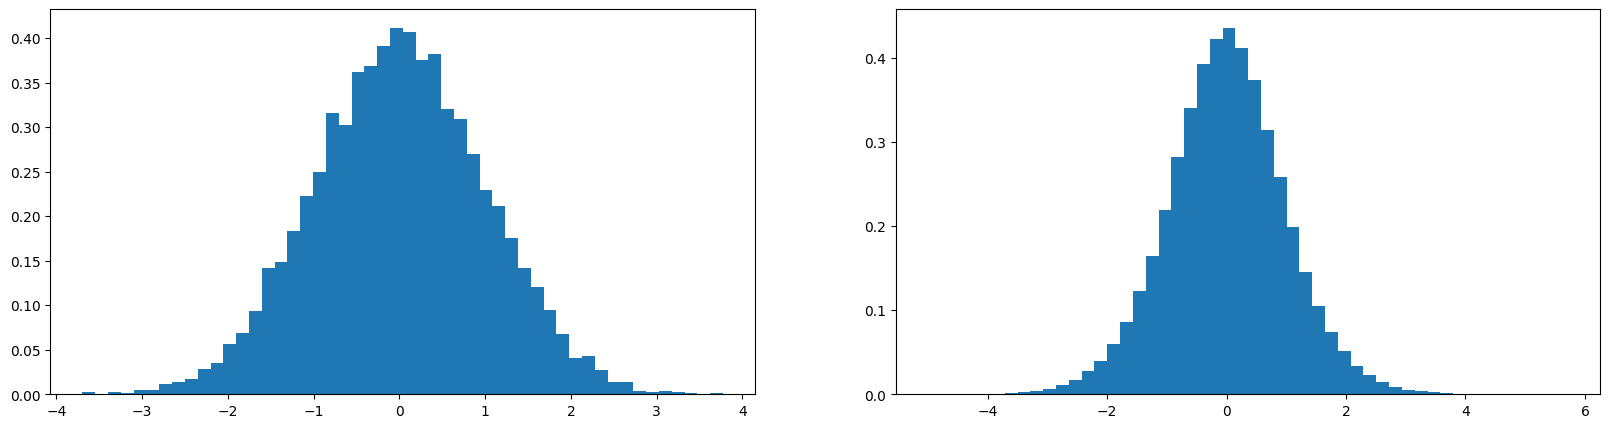

In [58]:
# what is a good initialization for weights and biases?
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) # the stddev has gone from 1 to 3 after w. the gaussian expands

# scaling w will help us preserve the stddev close to 1. 
# mathematically, you divide by sqrt(fan-in). fan_in = # input columns.

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [68]:
hpreact.shape

torch.Size([32, 200])

In [72]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [76]:
# optimize
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # build the minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # indices into the training set
    Xb, Yb = Xtr[ix], Ytr[ix] # the actual training subset

    # forward pass
    emb = C[Xb] # lut into embedding
    embcat = emb.view(emb.shape[0], -1) # concatenate the three vectors into a constant length-3 token

    # we want hpreact ~ N(0, 1).
    # batch-normalization:
    #  why not just do that by definition. normalize the hidden states so they are gaussian.
    # literally just map into zscores
    hpreact = embcat @ W1 + b1 # hidden layer before activation
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

    # but we can't do this on every batch. we want the distribution to move around.
    # allow backprop to tell us how to shift it.
    # introduce the bngain and bnbias.
    # so it can move the distribution around.
    hpreact = hpreact * bngain + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss.

    # recall that
    # XEL is given by NLL on softmax:
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    # NLL(avg) = -probs.log().mean()

    # backwards
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.7900
  10000/ 200000: 2.1688
  20000/ 200000: 2.4154
  30000/ 200000: 2.4466
  40000/ 200000: 1.9891
  50000/ 200000: 2.3907
  60000/ 200000: 2.4331
  70000/ 200000: 2.0376
  80000/ 200000: 2.4163
  90000/ 200000: 2.1735
 100000/ 200000: 1.9519
 110000/ 200000: 2.3468
 120000/ 200000: 2.0179
 130000/ 200000: 2.4662
 140000/ 200000: 2.3045
 150000/ 200000: 2.1351
 160000/ 200000: 1.9420
 170000/ 200000: 1.7860
 180000/ 200000: 1.9887
 190000/ 200000: 1.9237


torch.Size([32, 200])


(array([155., 180., 151., 170., 165., 145., 134., 102., 127., 122., 122.,
        107.,  95., 114.,  88.,  99.,  98.,  98., 114., 115.,  98., 101.,
        105., 121.,  93.,  89., 110., 104., 103.,  91., 107., 109., 108.,
         95., 128., 107., 137., 116., 114., 126., 127., 147., 152., 162.,
        161., 198., 169., 194., 225., 202.]),
 array([-9.98971939e-01, -9.59029787e-01, -9.19087634e-01, -8.79145482e-01,
        -8.39203329e-01, -7.99261177e-01, -7.59319024e-01, -7.19376872e-01,
        -6.79434719e-01, -6.39492567e-01, -5.99550414e-01, -5.59608262e-01,
        -5.19666109e-01, -4.79723957e-01, -4.39781804e-01, -3.99839652e-01,
        -3.59897499e-01, -3.19955347e-01, -2.80013194e-01, -2.40071042e-01,
        -2.00128889e-01, -1.60186737e-01, -1.20244584e-01, -8.03024316e-02,
        -4.03602791e-02, -4.18126583e-04,  3.95240259e-02,  7.94661784e-02,
         1.19408331e-01,  1.59350483e-01,  1.99292636e-01,  2.39234788e-01,
         2.79176941e-01,  3.19119093e-01,  3.59061

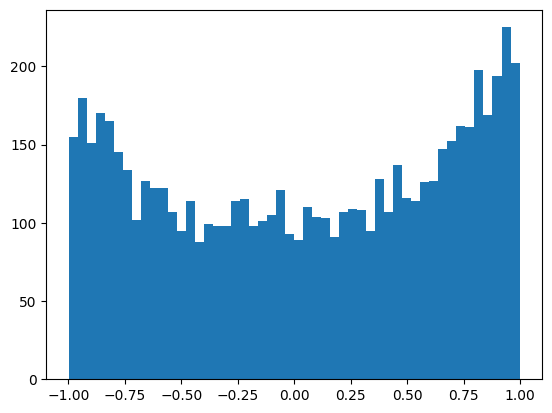

In [47]:
print(h.shape)
h # has many +/-1 values... this is weird because it shows asymptotic behavior.b
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   1.,   0.,   4.,   3.,   4.,   7.,   9.,   9.,  17.,  28.,
         40.,  47.,  76.,  73., 105., 134., 176., 201., 207., 226., 297.,
        278., 315., 368., 389., 378., 340., 353., 344., 297., 285., 273.,
        222., 204., 174., 108.,  98.,  90.,  60.,  43.,  28.,  26.,  19.,
         12.,  11.,   9.,   2.,   3.,   5.]),
 array([-3.78636837e+00, -3.64087019e+00, -3.49537201e+00, -3.34987383e+00,
        -3.20437565e+00, -3.05887747e+00, -2.91337929e+00, -2.76788111e+00,
        -2.62238293e+00, -2.47688475e+00, -2.33138657e+00, -2.18588839e+00,
        -2.04039021e+00, -1.89489202e+00, -1.74939384e+00, -1.60389566e+00,
        -1.45839748e+00, -1.31289930e+00, -1.16740112e+00, -1.02190294e+00,
        -8.76404762e-01, -7.30906582e-01, -5.85408401e-01, -4.39910221e-01,
        -2.94412041e-01, -1.48913860e-01, -3.41567993e-03,  1.42082500e-01,
         2.87580681e-01,  4.33078861e-01,  5.78577042e-01,  7.24075222e-01,
         8.69573402e-01,  1.01507158e+00,  1.16056

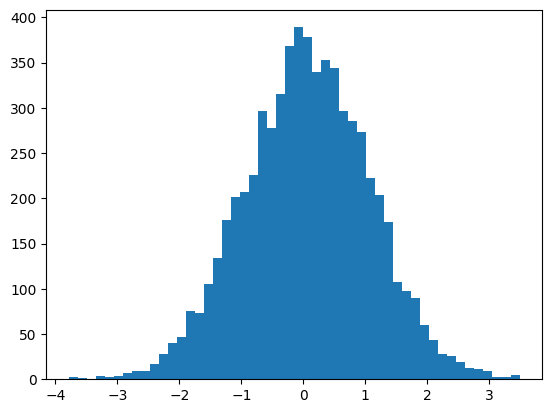

In [48]:
# why?
# broad distribution. large stddev
# but why is this a problem?
# the gradient at extreme values of tanh is very shallow. bad! slow convergence.

# to fix this, we can make W1, b1 close to zero just as we did before too.

# the deeper the network, the more important your initializations are.

plt.hist(hpreact.view(-1).tolist(), 50)

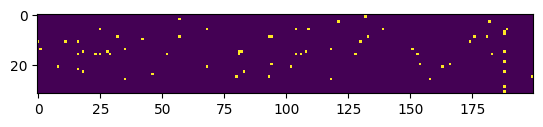

In [49]:
# completely white columns correspond to a "dead" neuron.
# it means the hidden layer is fully outside of the tanh
# slope regime, so it won't learn because the gradient
# vanishes.
plt.imshow(h.abs() > 0.99, interpolation='nearest')

In [20]:
# with randn initialized W2:
logits[0] # extreme values! confidently wrong. want it close to zero.

tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)

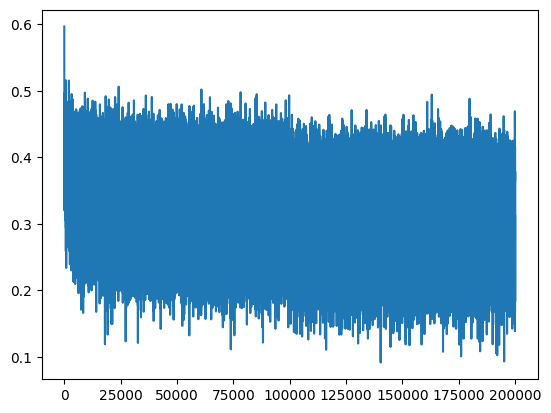

In [66]:
plt.plot(lossi)

In [98]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [99]:
# evaluate the train and validation loss
@torch.no_grad
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val" : (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    hpreact = (emb.view(x.shape[0], -1) @ W1 + b1)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.070509910583496
val 2.107753276824951


In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward passes only
        emb = C[torch.tensor([context])] # (n=1, block_size, n_embed)
        hpreact = (emb.view(1, -1) @ W1 + b1)
        hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break # if itos[ix] == "."
    print(''.join(itos[i] for i in out))

carmahzaal.
harlikimri.
reetlanna.
sane.
mahnee.
delynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quinn.
shoisea.
jadbi.
wavero.
dearisia.
kaellinsley.
dae.
oia.


In [11]:
# calculating expected initial loss.
# any given prob for a char should be:
p = torch.tensor(1/27.0)
# and the NLL should be
-p.log()

tensor(3.2958)

In [13]:
# smaller example.
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

# basically, you want logits to be close to zero at initialization.
# but why not zero?

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))